In [1]:
import io
import pandas as pd
import requests
import matplotlib.pyplot as plt
import zipfile
%matplotlib inline

### Country Populations

https://data.worldbank.org/indicator/SP.POP.TOTL

In [2]:
r = requests.get("http://api.worldbank.org/v2/en/indicator/SP.POP.TOTL?downloadformat=csv", stream=True)
z = zipfile.ZipFile(io.BytesIO(r.content))
f = z.open('API_SP.POP.TOTL_DS2_en_csv_v2_821007.csv')
pop = pd.read_csv(f, header=2)

In [3]:
pop = pop.rename(columns={'Country Name': 'country', 'Country Code': 'ccode', '2018': 'pop_count'})
pop['country'] = pop['country'].str.upper()
pop = pop.loc[:,['country', 'ccode', 'pop_count']]
pop.sample(5)

,country,ccode,pop_count
53,GERMANY,DEU,82927922.0
155,NORTH MACEDONIA,MKD,2082958.0
188,POLAND,POL,37978548.0
75,FRANCE,FRA,66987244.0
14,BURUNDI,BDI,11175378.0


### COVID-19 Case Count

https://experience.arcgis.com/experience/685d0ace521648f8a5beeeee1b9125cd

In [4]:
raw = requests.get("https://services.arcgis.com/5T5nSi527N4F7luB/arcgis/rest/services/COVID_19_HistoricCasesByCountry(pt)View/FeatureServer/0/query?f=json&where=1%3D1&returnGeometry=false&spatialRel=esriSpatialRelIntersects&outFields=OBJECTID%2Ccum_conf%2CDateOfDataEntry%2CADM0_NAME&orderByFields=DateOfDataEntry%20asc&resultOffset=0&resultRecordCount=2000&cacheHint=true")

In [5]:
raw.json()['features'][:3]

[{'attributes': {'OBJECTID': 908,
   'cum_conf': 1,
   'DateOfDataEntry': 1579651200000,
   'ADM0_NAME': 'JAPAN'}},
 {'attributes': {'OBJECTID': 1370,
   'cum_conf': 1,
   'DateOfDataEntry': 1579651200000,
   'ADM0_NAME': 'REPUBLIC OF KOREA'}},
 {'attributes': {'OBJECTID': 1736,
   'cum_conf': 4,
   'DateOfDataEntry': 1579651200000,
   'ADM0_NAME': 'THAILAND'}}]

In [6]:
data = pd.json_normalize(raw.json(), record_path='features')
data = data.rename(columns={'attributes.OBJECTID':'id', 'attributes.ADM0_NAME': 'country',
                            'attributes.cum_conf':'cumsum', 'attributes.DateOfDataEntry':'unixtime'})
data['date'] = pd.to_datetime(data['unixtime'], origin='unix', unit='ms')
data.sample(5)

,id,cumsum,unixtime,country,date
472,1694,1,1581638400000,SWEDEN,2020-02-14
935,1723,6,1582848000000,SWITZERLAND,2020-02-28
589,318,8,1582070400000,CANADA,2020-02-19
475,1866,9,1581638400000,UNITED KINGDOM,2020-02-14
978,1211,1,1582934400000,NIGERIA,2020-02-29


### Merged data

In [7]:
keys = ['BELGIUM', 'NETHERLANDS', 'LUXEMBOURG', 'FRANCE', 'ITALY', 'GERMANY', 'CHINA']

In [8]:
merged = pop.merge(data, on='country', how='right')
merged['normalized'] = 1e5*merged['cumsum']/merged['pop_count']
merged.sample(5)

,country,ccode,pop_count,id,cumsum,unixtime,date,normalized
1212,MALAYSIA,MYS,31528585.0,1067,22,1582070400000,2020-02-19,0.069778
1625,SWEDEN,SWE,10183175.0,1712,15,1583193600000,2020-03-03,0.147302
1296,NEPAL,NPL,28087871.0,1159,1,1581811200000,2020-02-16,0.003560
1830,VIET NAM,NaN,NaN,1960,14,1581292800000,2020-02-10,NaN
1022,KUWAIT,KWT,4137309.0,979,58,1583452800000,2020-03-06,1.401877


In [9]:
data.to_csv('covid19_{:%Y%m%d}.csv'.format(pd.Timestamp.now()))

In [10]:
cross = merged.pivot_table(index='date', columns='country', values='cumsum')
cross.tail(5)[keys]

country,BELGIUM,NETHERLANDS,LUXEMBOURG,FRANCE,ITALY,GERMANY,CHINA
date,,,,,,,
2020-03-07,169.0,128.0,2.0,613.0,4636.0,639.0,80813.0
2020-03-08,169.0,188.0,2.0,939.0,5883.0,847.0,80859.0
2020-03-09,200.0,265.0,2.0,1116.0,7375.0,1112.0,80904.0
2020-03-10,239.0,321.0,5.0,1402.0,9172.0,1139.0,80924.0
2020-03-11,267.0,382.0,5.0,1774.0,10149.0,1296.0,80955.0


In [11]:
ncross = merged.pivot_table(index='date', columns='country', values='normalized')
ncross.tail(5)[keys]

country,BELGIUM,NETHERLANDS,LUXEMBOURG,FRANCE,ITALY,GERMANY,CHINA
date,,,,,,,
2020-03-07,1.479592,0.742846,0.329095,0.915100,7.671523,0.770549,5.802489
2020-03-08,1.479592,1.091056,0.329095,1.401759,9.735024,1.021369,5.805792
2020-03-09,1.750996,1.537924,0.329095,1.665989,12.203944,1.340924,5.809023
2020-03-10,2.092441,1.862920,0.822736,2.092936,15.177570,1.373482,5.810459
2020-03-11,2.337580,2.216932,0.822736,2.648265,16.794282,1.562803,5.812684


### Trends

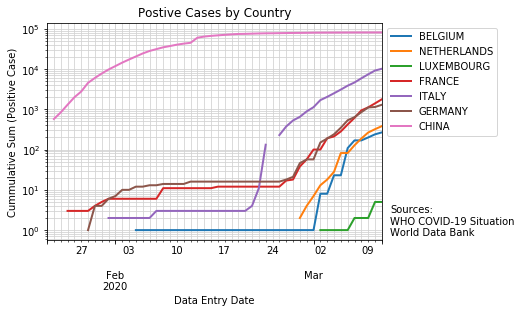

In [12]:
axe = cross[keys].plot(logy=True, linewidth=2)
axe.set_title("Postive Cases by Country")
axe.set_xlabel("Data Entry Date")
axe.set_ylabel("Cummulative Sum (Positive Case)")
axe.grid(which='both', color='lightgray')
axe.legend(bbox_to_anchor=(1,1), loc='upper left')
_ = axe.get_figure().text(0.92, 0.14, "Sources:\nWHO COVID-19 Situation\nWorld Data Bank")

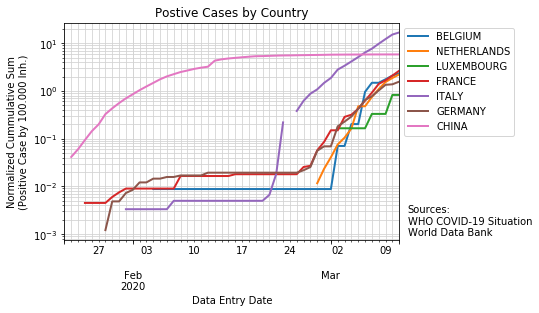

In [13]:
axe = ncross[keys].plot(logy=True, linewidth=2)
axe.set_title("Postive Cases by Country")
axe.set_xlabel("Data Entry Date")
axe.set_ylabel("Normalized Cummulative Sum\n(Positive Case by 100.000 Inh.)")
axe.grid(which='both', color='lightgray')
axe.legend(bbox_to_anchor=(1,1), loc='upper left')
_ = axe.get_figure().text(0.92, 0.14, "Sources:\nWHO COVID-19 Situation\nWorld Data Bank")

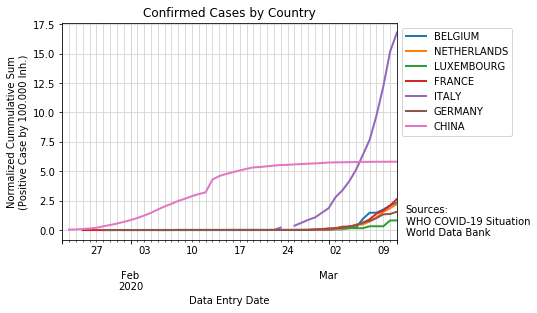

In [14]:
axe = ncross[keys].plot(linewidth=2)
axe.set_title("Confirmed Cases by Country")
axe.set_xlabel("Data Entry Date")
axe.set_ylabel("Normalized Cummulative Sum\n(Positive Case by 100.000 Inh.)")
axe.grid(which='both', color='lightgray')
axe.legend(bbox_to_anchor=(1,1), loc='upper left')
_ = axe.get_figure().text(0.92, 0.14, "Sources:\nWHO COVID-19 Situation\nWorld Data Bank")

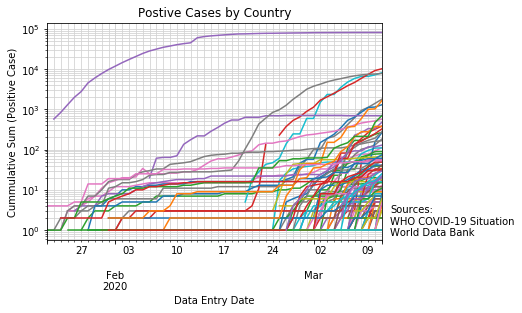

In [15]:
axe = cross.plot(logy=True)
axe.set_title("Postive Cases by Country")
axe.set_xlabel("Data Entry Date")
axe.set_ylabel("Cummulative Sum (Positive Case)")
axe.grid(which='both', color='lightgray')
axe.legend(bbox_to_anchor=(1,1), loc='upper left')
_ = axe.get_figure().text(0.92, 0.14, "Sources:\nWHO COVID-19 Situation\nWorld Data Bank")
axe.legend().remove()

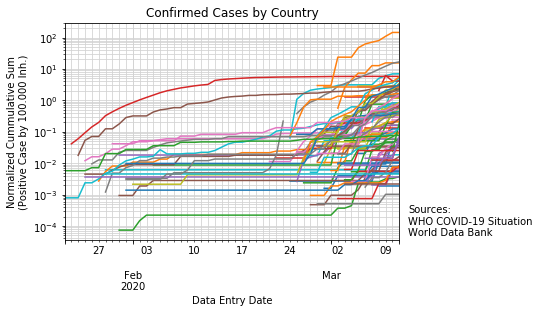

In [16]:
axe = ncross.plot(logy=True)
axe.set_title("Confirmed Cases by Country")
axe.set_xlabel("Data Entry Date")
axe.set_ylabel("Normalized Cummulative Sum\n(Positive Case by 100.000 Inh.)")
axe.grid(which='both', color='lightgray')
axe.legend(bbox_to_anchor=(1,1), loc='upper left')
_ = axe.get_figure().text(0.92, 0.14, "Sources:\nWHO COVID-19 Situation\nWorld Data Bank")
axe.legend().remove()